<a href="https://colab.research.google.com/github/bulinayas/Deep-deep-learning/blob/main/%5Bpractice%5Dneuron_logloss_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Обучение нейрона с помощью функции потерь LogLoss</b></h2>

---

<h3 style="text-align: center;"><b>Напоминание</b></h3>

Почти любой алгоритм машинного обучения, решающий задачу *классификации* или *регрессии*, работает так:

1. (*стадия инициализации*) Задаются его **гиперпараметры**, то есть те величины, которые не "выучиваются" алгоритмом в процессе обучения самостоятельно 
2. (*стадия обучения*) Алгоритм запускается на данных, **обучаясь** на них и меняя свои **параметры** (не путать с *гипер*параметрами) каким-то определённым образом (например, с помощью *метода градиентного спуска*), исходя из функции потерь (её называют *loss function*). Функция потерь, по сути, говорит, где и как ошибается модель
3.  (*стадия предсказания*) Модель готова, и теперь с помощью неё можно делать **предсказания** на новых объектах

В данном ноутбуке будет решаться задача **бинарной классификации** с помощью нейрона:  
- *Входные данные*: матрица $X$ размера $(n, m)$ и столбец $y$ из нулей и единиц размера $(n, 1)$. Строкам матрицы соответствуют объекты, столбцам - признаки (то есть строка $i$ есть набор признаков (*признаковое описание*) объекта $x_i$).
- *Выходные данные*: столбец $\hat{y}$ из нулей и единиц размера $(n, 1)$ - предсказания алгоритма.

Модель нейрона в биологии и в deep learning:  

![title](http://lamda.nju.edu.cn/weixs/project/CNNTricks/imgs/neuron.png)

<h3 style="text-align: center;"><b>Нейрон с сигмоидой</b></h3>

Снова рассмотрим нейрон с сигмоидой, то есть $$f(x) = \sigma(x)=\frac{1}{1+e^{-x}}$$ на рисунке выше.

На предыдущем занятии мы установили, что **обучение нейрона с сигмоидой с квадратичной функцией потерь**:  

$$MSE(w, x) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{n}\sum_{i=1}^{n} (\sigma(w \cdot x_i) - y_i)^2$$    

где $w \cdot x_i$ - скалярное произведение, а $\sigma(w \cdot x_i) =\frac{1}{1+e^{-w \cdot x_i}} $ - сигмоида - **неэффективно**, то есть мы увидели, что даже за большое количество итераций нейрон предсказывает плохо.

Давайте ещё раз взглянем на формулу для градиентного спуска от функции потерь $J$ по весам нейрона:

$$ \frac{\partial Loss}{\partial w} = \frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

А теперь смотрим на график сигмоиды:

<img src="https://cdn-images-1.medium.com/max/1200/1*IDAnCFoeXqWL7F4u9MJMtA.png" width=500px height=350px>

**Её значения: числа от 0 до 1.**

Если получше проанализировать формулу, то теперь можно заметить, что, поскольку сигмоида принимает значения между 0 и 1 (а значит (1-$\sigma$) тоже принимает значения от 0 до 1), то мы умножаем $X^T$ на столбец $(\sigma(w \cdot X) - y)$ из чисел от -1 до 1, а потом ещё на столбцы $\sigma(w \cdot X)$ и $(1 - \sigma(w \cdot X))$ из чисел от 0 до 1. Таким образом в лучшем случае $\frac{\partial{J}}{\partial{w}}$ будет столбцом из чисел, порядок которых максимум 0.01 (в среднем, понятно, что если сигмоида выдаёт все 0, то будет 0, если все 1, то тоже 0). После этого мы умножаем на шаг градиентного спуска, который обычно порядка 0.001 или 0.01 максимум. То есть мы вычитаем из весов числа порядка ~0.0001. Медленновато спускаемся, не правда ли? Это называют **проблемой затухающих градиентов**.

Всё верно. В задачах классификации, в которых моделью является нейрон с сигмоидной функцией активации, предсказывающий "вероятности" принадлженостей к классам, почти никогда не используют квадратичную функцию потерь $J$. Вместо неё придумали другую прекрасную функцию потерь -- **LogLoss**:  

$$LogLoss(\hat{y}, y) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\sigma(w \cdot x_i)) + (1 - y_i) \log(1 - \sigma(w \cdot x_i))$$

где, как и прежде, $y$ - столбец $(n, 1)$ из истинных значений классов, а $\hat{y}$ - столбец $(n, 1)$ из предсказаний нейрона.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [2]:
def loss(y_pred, y):
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

Отметим, что сейчас речь идёт именно о **бинарной классификации (на два класса)**, в многоклассовой классификации используется функция потерь под названием *кросс-энтропия*, которая является обобщением LogLoss'а на случай нескольких классов.

Почему же теперь всё будет лучше? Раньше была проблема умножения маленьких чисел в градиенте. Давайте посмотрим, что теперь:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
-\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)(\sigma(w \cdot x_i))_{w_j}' = -\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij} = $$
$$-\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{ij}$$

* Градиент $Loss$'а по вектору весов -- это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$ (помним, что весов всего $m$):

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i1} \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i2} \\
           \vdots \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T \left(\hat{y} - y\right)$$

По аналогии с нейроном выведите формулу для свободного члена (bias'а) $b$:

$$ \frac{\partial Loss}{\partial b} = 
-\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i + b)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i + b)}\right)(\sigma(w \cdot x_i + b))_{b}' = -\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i + b)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i + b)}\right)\sigma(w \cdot x_i + b)(1 - \sigma(w \cdot x_i + b))*1 = $$
$$-\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)$$

Получили новое правило для обновления. Заметим, что это в точности то правило обновления весов для градиентного спуска, которое мы использовали для перцептрона (только другая функция активации). Получается, что мы пришли к этому правилу "по-честному", сделав функцией активации сигмоиду и введя новую функию потерь -- LogLoss, а когда реализовывали перцептрон, мы просто сказали (воспользовавшись *правилом Хебба*), что $f'(x)$ возьмём единицей, то есть тут имеет место интересная связь градиентного спуска и метода коррекции ошибки.

Отсюда очевидно, что код для нейрона с такой функцией потерь не будет ничем отличаться от кода для перцептрона, за исключением метода `self.activate()` и самого подсчёта `loss()`. Напишем:

In [3]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1 / (1 + np.exp(-x))

Реализуем нейрон с функцией потерь LogLoss:

In [8]:
class Neuron:
    
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b
        
    def activate(self, x):
        return sigmoid(x)

    def forward_pass(self, X):
        """
        Эта функция рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица объектов размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами перцептрона 
        """
        y_pred=np.zeros((X.shape[0],1))
        y_pred=self.activate(X @ self.w.reshape(X.shape[1],1)+self.b)
        return y_pred.reshape(-1,1)
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.1):
        """
        Обновляет значения весов нейрона в соответствие с этим объектом
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n=X.shape[0]
        y=np.array(y).reshape(-1,1)

        dw=(X.T @ (y_pred-y))/n
        db=(y_pred-y).mean(axis=0)

        self.w-=learning_rate*dw
        self.b-=learning_rate*db
    
    def fit(self, X, y, num_epochs=5000):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: J_values -- вектор значений функции потерь
        """
        self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
        self.b = 0  # смещение
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred=self.forward_pass(X)
            Loss_values.append(loss(y_pred,y))
            self.backward_pass(X,y,y_pred)

        return Loss_values

<h3 style="text-align: center;"><b>Тестирование</b></h3>

Протестируем нейрон, обученный с новой функцией потерь, на тех же данных, что и в предыдущем ноутбуке:

**Проверка forward_pass()**

In [9]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 3.],
              [2., 4.],
              [-1., -3.2]])

neuron = Neuron(w, b)
y_pred = neuron.forward_pass(X)
print ("y_pred = " + str(y_pred))

y_pred = [[0.99987661]
 [0.99999386]
 [0.00449627]]


**Проверка backward_pass()**

In [10]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [11]:
neuron.backward_pass(X, y, y_pred)

print ("w = " + str(neuron.w))
print ("b = " + str(neuron.b))

w = [[0.9001544 ]
 [1.76049276]]
b = [1.99985444]


Загрузим данные (яблоки и груши):

In [12]:
data = pd.read_csv("./apples_pears.csv")

In [13]:
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


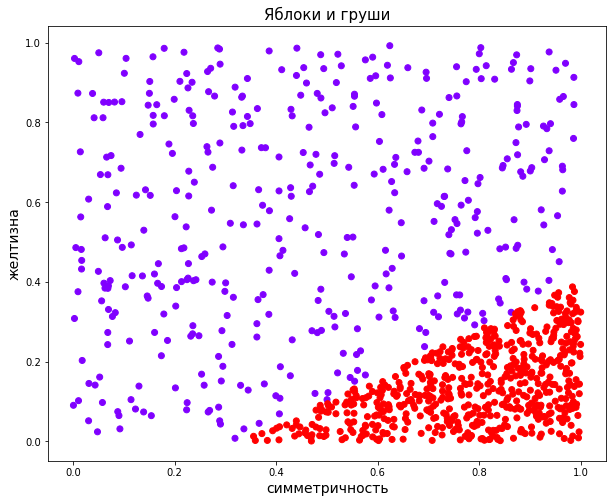

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Обозначим, что здесь признаки, а что - классы:

In [15]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

**Вывод функции потерь**  
Функция потерь должна убывать и в итоге стать близкой к 0

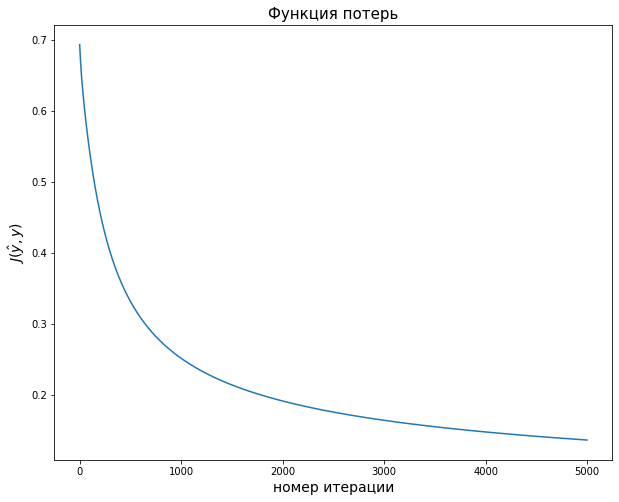

CPU times: user 1.19 s, sys: 12.8 ms, total: 1.2 s
Wall time: 1.23 s


In [17]:
%%time
neuron = Neuron()
J_values = neuron.fit(X,y)

plt.figure(figsize=(10, 8))
plt.plot(J_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$J(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как теперь нейрон классифицировал объекты из выборки:

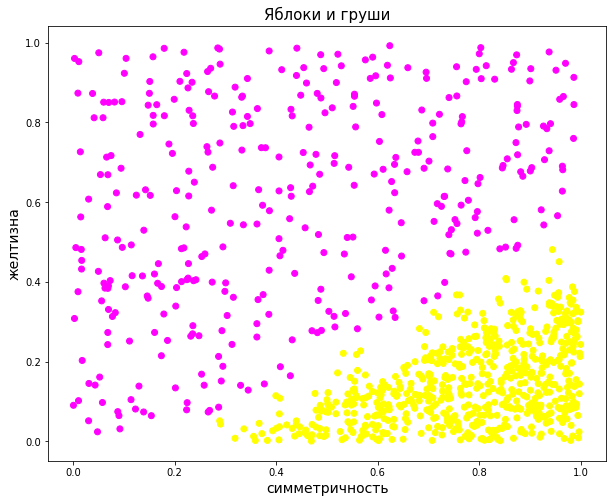

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Видим, что с LogLoss в случае классификации работать лучше, чем с квадратичной функцией потерь (с 5000 итераций и lr=0.1 здесь лучше, чем с 5000 итераций и lr=0.1 в нейроне с MSE). 

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

0). Статья от Стэнфорда: http://cs231n.github.io/neural-networks-1/

1). Хорошая статья про функции активации: https://www.jeremyjordan.me/neural-networks-activation-functions/

2). [Видео от Siraj Raval](https://www.youtube.com/watch?v=-7scQpJT7uo)

3). Современная статья про функции активации. Теперь на хайпе активация **$swish(x) = x\sigma (\beta x)$:** https://arxiv.org/pdf/1710.05941.pdf (кстати, при её поиске в некоторой степени использовался neural architecture search)

4). **SeLU** имеет очень интересные, доказанные с помощью теории вероятностей свойства: https://arxiv.org/pdf/1706.02515.pdf (да, в этой статье 102 страницы)